In [2]:
import os
import pandas as pd
from tqdm.notebook import tqdm

LOCAL_HISTORY_DIRECTORY = "observation_files/"
            

thing_directories = [x[0] for x in os.walk(LOCAL_HISTORY_DIRECTORY) if x[0] != LOCAL_HISTORY_DIRECTORY]

primary_signals_dfs = []

for thing_directory in tqdm(thing_directories, desc=f'Analyzing..', total=len(thing_directories)):
    thing_name = thing_directory.split("/")[-1]
    file_names = [x[2] for x in os.walk(thing_directory)]
    for file_name in file_names[0]:      
        if "primary_signal" in file_name:
            df = pd.read_csv(thing_directory + "/" + file_name)
            primary_signals_dfs.append(df)
                
primary_signals_df = pd.concat(primary_signals_dfs)

primary_signals_df.to_csv("primary_signals_df.csv", index=False)

Analyzing..:   0%|          | 0/18059 [00:00<?, ?it/s]

In [13]:
import pandas as pd

# Read df from file
primary_signals_df = pd.read_csv("primary_signals_df.csv")

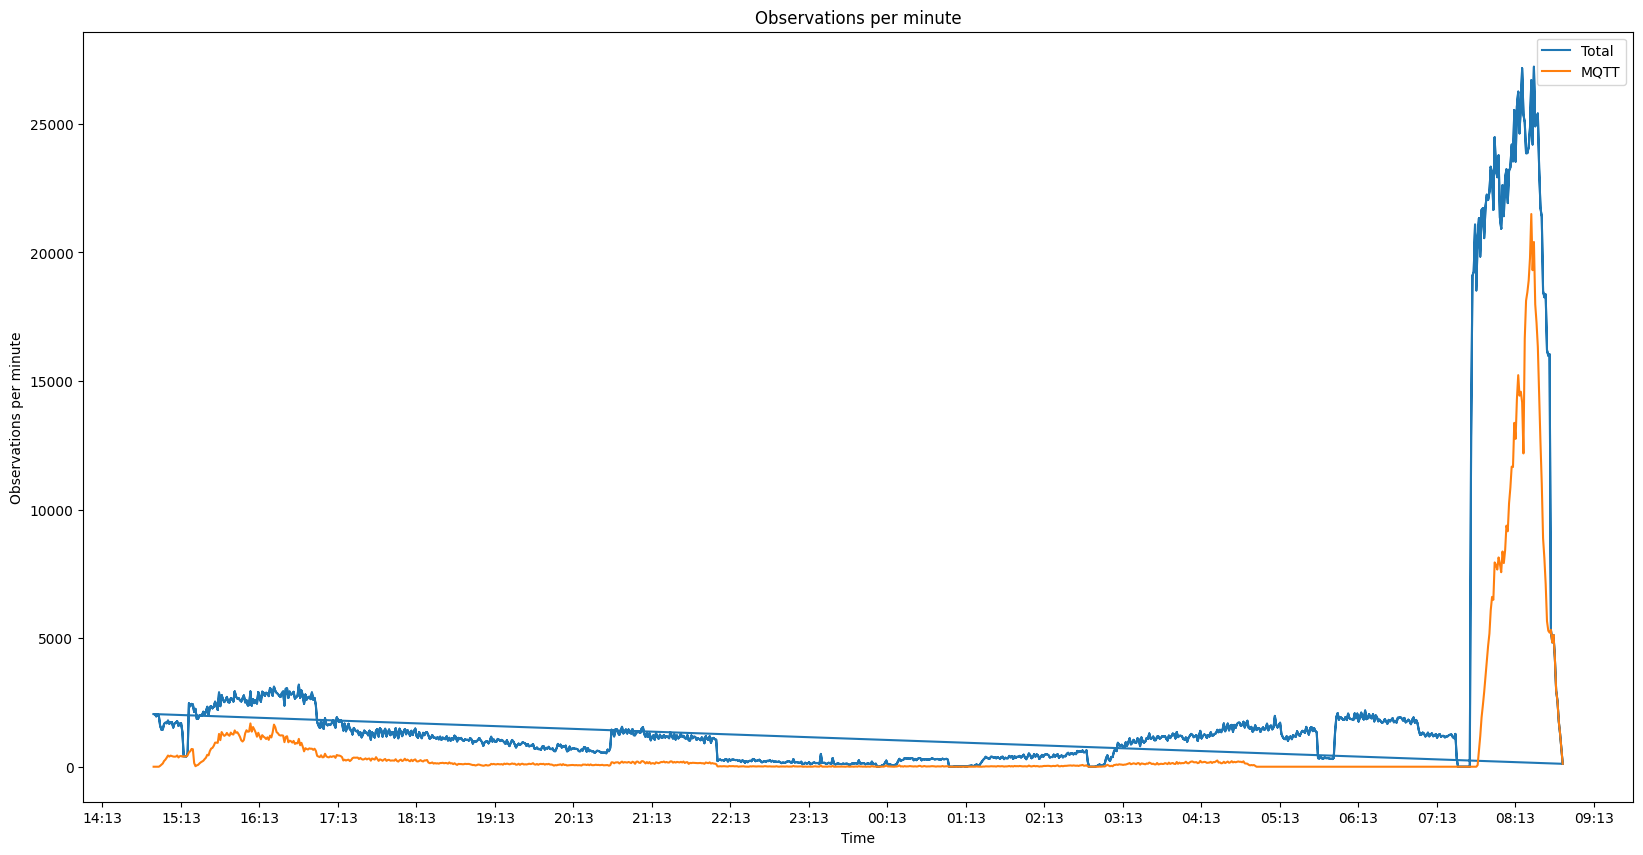

In [14]:
import pandas as pd

# Convert first three columns to datetime (date format is "2006-01-02T15:04:05.000Z")
primary_signals_df['phenomenonTime'] = primary_signals_df['phenomenonTime'].str.replace('delMe', '')
primary_signals_df['phenomenonTime'] = pd.to_datetime(primary_signals_df['phenomenonTime'], format='%Y-%m-%dT%H:%M:%SZ')
primary_signals_df['resultTime'] = pd.to_datetime(primary_signals_df['resultTime'], format='mixed')
primary_signals_df['receivedTime'] = pd.to_datetime(primary_signals_df['receivedTime'], format='mixed')

# Sort by resultTime
primary_signals_df = primary_signals_df.sort_values(by=['resultTime'])

# Eliminate rows where the resultTime is a duplicate
primary_signals_df = primary_signals_df.drop_duplicates(subset=['resultTime'])

first_result_time = primary_signals_df['resultTime'].iloc[0]

last_result_time = primary_signals_df['resultTime'].iloc[-1]

current_time = first_result_time

total_observations_per_minute = pd.DataFrame({
    'time': pd.Series(dtype='datetime64[ns]'),
    'count': pd.Series(dtype='int')
})

mqtt_observations_per_minute = pd.DataFrame({
    'time': pd.Series(dtype='datetime64[ns]'),
    'count': pd.Series(dtype='int') 
})

while current_time < last_result_time:
    # Get all observations within the current minute
    observations_in_current_minute = primary_signals_df[(primary_signals_df['resultTime'] >= current_time) & (primary_signals_df['resultTime'] < current_time + pd.Timedelta(minutes=1))]
    observations_per_minute = pd.concat([observations_per_minute, pd.DataFrame({'time': [current_time], 'count': [len(observations_in_current_minute)]})])
    
    
    # Get all observations within the current minute where the source column is "mqtt"
    mqtt_observations_in_current_minute = observations_in_current_minute[observations_in_current_minute['source'] == 'mqtt']
    mqtt_observations_per_minute = pd.concat([mqtt_observations_per_minute, pd.DataFrame({'time': [current_time], 'count': [len(mqtt_observations_in_current_minute)]})])
    
    current_time = current_time + pd.Timedelta(minutes=1)
    
    
# Plot the results in a line graph
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(20,10))
ax.plot(observations_per_minute['time'], observations_per_minute['count'], label='Total')
ax.plot(mqtt_observations_per_minute['time'], mqtt_observations_per_minute['count'], label='MQTT')
ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=60))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set_xlabel('Time')
ax.set_ylabel('Observations per minute')
ax.set_title('Observations per minute')
ax.legend()
plt.show()

    